In this notebook, we explore a **sentiment analysis task using the Sentiment140 dataset**. This dataset contains labeled tweets with positive and negative sentiments, and we will walk through the steps necessary to preprocess the data, build a deep learning model, and evaluate its performance. By following this process, you’ll learn the fundamentals of working with text data and applying machine learning techniques for sentiment analysis.

Steps Overview:

- Download the Dataset:
- Download the Sentiment140 dataset from Kaggle.
- Data Preprocessing:
- Clean and prepare the text data by removing noise (URLs, mentions, etc.).
- Tokenization and Padding:
- Tokenize the text and pad sequences to ensure consistent input size.
- Build the Model:
- Construct a simple LSTM-based model for sentiment analysis.
- Train the Model:
- Train the model using the preprocessed data.
- Evaluate the Model:
- Assess the model's performance using metrics like accuracy and loss.
- Metrics for Sentiment Analysis:
- Explore additional metrics (precision, recall, F1-score) for a more detailed evaluation


In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 94%|█████████▍| 76.0M/80.9M [00:02<00:00, 40.9MB/s]


Path to dataset files: /home/azureuser/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2


In [9]:
import pandas as pd

# Load the dataset
df = pd.read_csv(path + "/training.1600000.processed.noemoticon.csv", encoding="latin1", header=None)
df.columns = ['target', 'id', 'date', 'query', 'user', 'text']

# Filter dataset for only target classes 0 and 4
df_filtered = df[df['target'].isin([0, 4])]

# Determine the minimum class count for equal sampling
min_class_count = df_filtered['target'].value_counts().min()

# Sample equal number of instances from each class
df_balanced = df_filtered.groupby('target').sample(n=min_class_count, random_state=42)

# Subsample to 10,000 instances if needed
df_balanced = df_balanced.sample(n=10000, random_state=42) if len(df_balanced) > 10000 else df_balanced

print(df_balanced['target'].value_counts())

# Inspect the first few rows
df_balanced.head()

df = df_balanced

target
0    5004
4    4996
Name: count, dtype: int64


In [11]:
import re
import string
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')

# Function to clean and preprocess text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\S+', '', text)  # Remove @mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    return text

# Apply the function to clean text data
df['cleaned_text'] = df['text'].apply(clean_text)

# Inspect cleaned text
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)
df[['text', 'cleaned_text']].head()
#df['target'].head()

2025-03-13 16:04:24.002481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-13 16:04:24.002540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-13 16:04:24.958980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 16:04:26.749038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 16:04:31.160380: W tensorflow/compiler/tf2

,text,cleaned_text
35078,15 minutes until the listening 1 hour 15 minu...,minutes until the listening hour minutes un...
72627,monday morning,monday morning
586004,just got this twitter and now im at my grandp...,just got this twitter and now im at my grandp...
320185,brushing my teeferz then heading my butt into ...,brushing my teeferz then heading my butt into ...
233425,new bears are looking great!....makes me want ...,new bears are looking greatmakes me want to wo...


In [12]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences to have the same length
max_length = 100  # Set a maximum length for padding
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_length)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

# Check shapes of data
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

Training data shape: (8000, 100), Validation data shape: (2000, 100)


In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, InputLayer

from tensorflow.keras.layers import Bidirectional
max_length = 100  # or your chosen padding length
model = Sequential([
    InputLayer(input_shape=(max_length,)),
    Embedding(input_dim=10000, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),
    LSTM(256),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

2025-03-13 16:05:24.596945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14793 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5
2025-03-13 16:05:26.499896: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          263168    
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 2068737 (7.89 MB)
Trainable params: 2068737 (7.89 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [14]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
250/250 [==============================] - 17s 42ms/step - loss: 0.6938 - accuracy: 0.5123 - val_loss: 0.6940 - val_accuracy: 0.4900
Epoch 2/10
250/250 [==============================] - 5s 20ms/step - loss: 0.6934 - accuracy: 0.5050 - val_loss: 0.6939 - val_accuracy: 0.4900
Epoch 3/10
250/250 [==============================] - 4s 16ms/step - loss: 0.6935 - accuracy: 0.5036 - val_loss: 0.6934 - val_accuracy: 0.4900
Epoch 4/10
250/250 [==============================] - 4s 17ms/step - loss: 0.6953 - accuracy: 0.5030 - val_loss: 0.6942 - val_accuracy: 0.4900
Epoch 5/10
250/250 [==============================] - 4s 15ms/step - loss: 0.6936 - accuracy: 0.4964 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 6/10
250/250 [==============================] - 4s 15ms/step - loss: 0.6933 - accuracy: 

2025-03-13 16:05:49.021787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-03-13 16:05:51.073412: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcac9a1c320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-13 16:05:51.073446: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-03-13 16:05:51.214832: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741881951.509520   10159 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training History:
        loss  accuracy  val_loss  val_accuracy
1   0.693771  0.512250  0.694047        0.4900
2   0.693359  0.505000  0.693888        0.4900
3   0.693466  0.503625  0.693388        0.4900
4   0.695270  0.503000  0.694187        0.4900
5   0.693573  0.496375  0.693035        0.5100
6   0.693322  0.497750  0.692985        0.5080
7   0.693669  0.506875  0.693344        0.4900
8   0.688602  0.540625  0.668879        0.6075
9   0.607181  0.685375  0.601858        0.6710
10  0.518404  0.751125  0.601722        0.7010


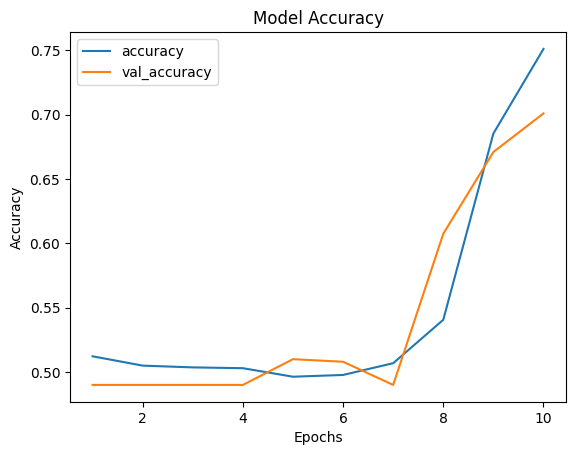

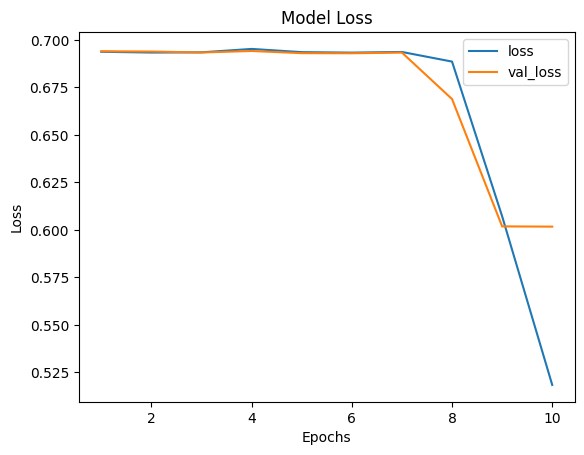

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the history to a pandas DataFrame
history_df = pd.DataFrame(history.history)

# Display the training history
history_df.index += 1  # Start epochs from 1
print("Training History:")
print(history_df)

# Plot accuracy and loss
history_df[['accuracy', 'val_accuracy']].plot(title="Model Accuracy", xlabel="Epochs", ylabel="Accuracy")
history_df[['loss', 'val_loss']].plot(title="Model Loss", xlabel="Epochs", ylabel="Loss")
plt.show()

In [17]:
from sklearn.metrics import classification_report

# Predict on validation set
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_val, y_pred))

63/63 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       980
           1       0.76      0.60      0.67      1020

    accuracy                           0.70      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.70      0.70      2000

